# Neural Network Library

## Layer Class

In [1]:
class Layer:
    def __init__(self, name=None, weights=None, bias=None):
        self.name = name
        self.x = None
        self.y = None
        self.weights = weights
        self.bias = bias
        self.delta = None
        self.isb = True
        
    def forward(self, x):
        self.y = self.weights.T * x
        return self.y
    
    def backward(self):
        return x        

## LinearLayer Class

In [2]:
class LinearLayer(Layer):
    def __init__(self, input_nodes, output_nodes, name="Linear",weights=None,bias=None):
        super().__init__(name=name)
        self.input_nodes=input_nodes
        self.output_nodes=output_nodes
        self.weights = weights
        self.bias = bias
        self.init_params()
        self.delta_weights=0
        self.delta_biases=0
        
    def init_params(self):
        if self.weights is None:
            self.weights = np.random.randn(self.input_nodes, self.output_nodes)
            self.bias = np.random.randn(self.output_nodes)
        self.parameters = self.input_nodes *  self.output_nodes + self.output_nodes
        
    def forward(self,x):
        self.x=x
        soma = np.dot(self.x, self.weights) + self.bias 
        self.y = soma
        return soma
    
    def backward(self, delta): 
        self.delta = delta 
        self.delta_weights += self.delta * np.atleast_2d(self.input).T 
        self.delta_biases += self.delta
        self.delta = np.dot(self.weights, self.delta)
        return self.delta
        

## Sigmoid Class

In [3]:
class Sigmoid(Layer):
    def __init__(self, input_nodes=None, name="Sigmoid"):
        super().__init__(name=name)
        self.input_nodes=input_nodes
        self.output_nodes=input_nodes
        self.parameters=0
        self.isb=None
        self.weights = 1
        self.bias=0
        self.delta_weights = 0
        self.delta_biases=0
        
    def forward(self, x):
        self.x=x
        self.y = 1 / (1 + np.exp(-x))
        
        return self.y
    def backward(self, delta):
        
        self.delta = delta * self.y*(1-self.y) 
        self.delta_weights += 0 
        self.delta_biases += 0 
        return self.delta

## HyperbolicTangent Class

In [4]:
class HyperbolicTangent(Layer):
    def __init__(self, input_nodes=None, name="HyperbolicTangent"):
        super().__init__(name=name)
        self.input_nodes=input_nodes
        self.output_nodes=input_nodes
        self.parameters=0
        self.isb=None
        self.weights = 1
        self.bias=0
        self.delta_weights = 0
        self.delta_biases=0
        
    def forward(self, x):
        self.x=x
        self.y = np.tanh(x)
        
        return self.y
    def backward(self, delta):
        
        self.delta *= (1-self.y **2) 
        self.delta_weights += 0 
        self.delta_biases += 0 
        return self.delta

## Softmax Class

In [5]:
class Softmax(Layer):
    def __init__(self, input_nodes=None, name="Softmax"):
        super().__init__(name=name)
        self.input_nodes=input_nodes
        self.output_nodes=input_nodes
        self.parameters=0
        self.isb=None
        self.weights = 1
        self.bias=0
        self.delta_weights = 0
        self.delta_biases=0
        
    def forward(self, r):
        r -= np.max(r)
        self.y = np.exp(r) / np.sum(np.exp(r))
        
        return self.y
        
        
    def backward(self, delta):
        
        self.delta = self.y*(1- self.y)
        
        return self.delta

## CrossentropyLoss Class

In [6]:
class CrossentropyLoss():
    def __init__(self, name="Crossentropy"):
        super().__init__()
        self.delta = None
        self.eps=1e-10
        self.error = None
        
    def forward(self, pred, target):
        y=target.astype(np.float)
        out=pred
        y = np.float64(y)
        out += self.eps
        y+=self.eps
        
        cse = -np.sum(y * np.nan_to_num(np.log(out), posinf=1, neginf=-1e-10)
                      + (1 - y) * np.nan_to_num(np.log(1 - out), posinf=1, neginf=-1e-10))
        
        return cse
        
    def backward(self, pred, target,softmax=False):
        y=target
        out=pred
        y = np.float64(y)
        out += self.eps
        
        if softmax:
            loss = y - out
            loss = np.nan_to_num(loss / self.layers[-1].activation_dfn(out))
        else:
            loss = -(np.nan_to_num(y / out, posinf=1, neginf=-1e-10) - np.nan_to_num((1 - y) / (1 - out), posinf=1, neginf=-1e-10))
        return loss

## Sequential Class

In [7]:
import os
import json

class Sequential(Layer):
    def __init__(self, name="NN Model"):
        self.layers = []
        self.column = ["LName", "Input", "Output", "Bias", "Parameters"]
        self.all_loss = {}
        self.lr = 1
        self.metrics = []
        self.parameters=0
        self.train_loss={}
        self.val_loss={}
        self.stop_loss=0.5
        
        
    def add_layer(self, layer):
        if(len(self.layers) > 0):
            prev_layer = self.layers[-1]
            if "Input Layer" not in prev_layer.name:
                layer.name=f"Output Layer ({layer.name})"
                if "Output Layer (" in prev_layer.name:
                    prev_layer.name = f"{prev_layer.name.split('Output Layer (')[-1][:-1]} {len(self.layers)}" 
            if layer.input_nodes == None:
                layer.input_nodes = prev_layer.output_nodes
                if layer.output_nodes is None:
                    layer.output_nodes = prev_layer.output_nodes
                
            if prev_layer.output_nodes != layer.input_nodes and layer.input_nodes != None:
                raise ValueError(f"This layer '{layer.name}' must have input_nodes={prev_layer.output_nodes} because '{prev_layer.name}' has output of {prev_layer.output_nodes}.")
        else:
            layer.name = f"Input Layer ({layer.name})"
        
        self.layers.append(layer)
    
    def build_model(self, loss, lr=0.001):
        self.loss = loss()
        self.lr=lr
    
    def forward(self, x):
        for l in self.layers:
            l.input = x
            x = l.forward(x)
            l.out = x
        self.pred = x
        return x
    
    def backward(self, loss,update=False):
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            if layer == self.layers[-1]:
                layer.backward(loss)
            else:
                nx_layer = self.layers[i+1]
                layer.backward(nx_layer.delta)  
        
        if update:   
            for l in self.layers:
                l.delta_weights /= (self.batch_size)
                l.delta_biases /= (self.batch_size)
                
                l.weights -= l.delta_weights*self.lr 
                l.bias += l.delta_biases*self.lr
                l.delta_weights=0
                l.delta_biases = 0
        
    def predict(self, X):
        out = []
        for x in X:
            out.append(self.forward(x))
        return out
    def display(self):
        plt.figure(figsize=(10,10))
        k = list(self.train_loss.keys())
        v = list(self.train_loss.values())
        plt.plot(k, v, "g-") 
        leg = ["Train Loss"]
        if self.val_loss!={}:
            k = list(self.val_loss.keys())
            v = list(self.val_loss.values())
            plt.plot(k, v, "r-")
            leg = ["Train Loss", "Val Loss"]
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(leg)
        plt.title("Loss vs Epoch")
        plt.show()
        
    def fit_model(self, X, Y, epochs=10, batch_size=32, show_every=1, val_split=0.1,stop_loss=0.05):
        self.batch_size = batch_size
        t1 = time.time()
        self.losses = []
        
        len_batch = int(len(X)/batch_size)
        if val_split!=None:
            curr_ind = np.arange(0, len(X), dtype=np.int32)
            val_e = int(len(X) * val_split)
            val_es = []
            while len(val_es) != val_e:
                rand_ind = np.random.randint(0, len(X))
                if rand_ind not in val_es:
                    val_es.append(rand_ind)
            val_e = np.array(val_es,dtype=np.int)
            val_x, val_y = X[val_e], Y[val_e]
            curr_ind = np.array([v for v in curr_ind if v not in val_e])  

            batches = []
        
        curr_ind = np.arange(0, len(X), dtype=np.int32)
        np.random.shuffle(curr_ind)

        while len(curr_ind) % batch_size != 0 :
            nx = len(curr_ind) % batch_size
            nx = curr_ind[:nx]
            curr_ind = np.hstack([curr_ind, nx])
            
        batches = np.split(curr_ind, batch_size)
        ploss = 0
        
        for e in range(epochs):            
            
            err = []
            for batch in batches:
                a = [] 
                curr_x, curr_y = X[batch], Y[batch]
                b = 0
                batch_loss = 0
                
                for x, y in zip(curr_x, curr_y):
                    out = self.forward(x)
                    update=True
                    softmax=False
                    if self.layers[-1].name=="Softmax":
                        softmax=True
                    error, loss = self.loss.forward(out, y), self.loss.backward(out, y, softmax)
                    batch_loss += loss
                    err.append(error)
                    update = False
                    if b == batch_size-1:
                        update = True
                        loss = batch_loss/batch_size
                    self.backward(loss, update)
                    b+=1
                    
            out = self.forward(X)
            loss = self.loss.forward(Y, out)
            if ploss==0:
                ploss=loss
            else:
                if abs(100*(ploss-loss)/ploss)<stop_loss:
                    print("Loss change is very small. Stopping training.")
                    break
            
            if e%show_every==0:
                self.train_loss[e]=loss
                show=f"Epoch {e} Train Loss: {loss}"
                if val_split is not None:
                    val_out = self.forward(val_x)
                    val_err = self.loss.forward(val_out, val_y)
                    self.val_loss[e] = val_err
                    show+= f"|| Validation Loss:{val_err.mean()}"

                print(show)
    
    def save_model(self, path="model.json"):
        d_model = {"model":str(type(self).__name__)}
        to_be_saved = ["name", "isb", "input_nodes", "output_nodes", "weights", "bias", "parameters"]
        for l in self.layers:
            current_layer = vars(l)
            
            values = {"type":str(type(l).__name__)}
            for key, value in current_layer.items():
                if key in to_be_saved:
                    if key in ["weights", "bias"]:
                        try:
                            value = value.tolist()
                        except:
                            value = value
                    values[key] = value
            d_model[l.name] = values
        json_dict = json.dumps(d_model)    
        with open(path, mode="w") as f:
            f.write(json_dict)


## Saving and Loading Model

A method to save  a model has been written inside a `Sequential` class.

In [8]:
def load_model(path="model.json"):
    models = {"Sequential": Sequential}
    layers = {"LinearLayer": LinearLayer, "Sigmoid": Sigmoid, "Softmax": Softmax, "HyperbolicTangent": HyperbolicTangent}
    with open(path, "r") as f:
        d_model = json.load(f)
        model = d_model["model"]
        model = models[model]()
        for layer, params in d_model.items():
            if layer != "model":
                try:
                    lyr = layers[params["type"]](input_nodes=params["input_nodes"],output_nodes=params["output_nodes"])
                except:
                    lyr = layers[params["type"]](input_nodes=params["input_nodes"])
                if params.get("weights"):
                    lyr.weights = params["weights"]
                if params.get("bias"):
                    lyr.bias = params["bias"]
                lyr.name = layer
                lyr.isb = params["isb"]
                lyr.input_nodes = params["input_nodes"]
                lyr.output_nodes = params["output_nodes"]
                lyr.parameters = params["parameters"]
                model.layers.append(lyr)
        return model


# Testing a Library: XOR Problem

In [9]:
import numpy as np
import pandas as pd
import time
pg = Sequential(name="Sequential")

xx = np.array([[0, 0], [1, 0], [1, 1], [0, 1]]).astype(np.float)
yy = np.array([[0], [1], [0], [1]]).astype(np.float).reshape(-1,1)

pg.add_layer(LinearLayer(input_nodes=2, output_nodes=2))
pg.add_layer(Sigmoid())
pg.add_layer(LinearLayer(input_nodes=2, output_nodes=1))
pg.add_layer(Sigmoid())

pg.build_model(loss=CrossentropyLoss, lr=0.01)
pg.fit_model(xx, yy, batch_size=1, epochs=100000, show_every=10000, val_split=None, stop_loss=0.5)

<ipython-input-9-136c21a60f75>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xx = np.array([[0, 0], [1, 0], [1, 1], [0, 1]]).astype(np.float)
<ipython-input-9-136c21a60f75>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yy = np.array([[0], [1], [0], [1]]).astype(np.float).reshape(-1,1)
<ipython-input-6-60b7572ef512>:9: DeprecationWar

Epoch 0 Train Loss: 36.36208655915666
Epoch 10000 Train Loss: 27.63058914260161
Epoch 20000 Train Loss: 26.244404522343853
Epoch 30000 Train Loss: 25.433512623154574
Epoch 40000 Train Loss: 24.858168141006352
Epoch 50000 Train Loss: 24.411892927973643
Epoch 60000 Train Loss: 24.047257659304734
Epoch 70000 Train Loss: 23.738961740616755
Epoch 80000 Train Loss: 23.471902834475955
Epoch 90000 Train Loss: 23.2363395610056


In [10]:
pg.predict(xx),yy

([array([1.]), array([1.]), array([0.99998346]), array([1.])],
 array([[1.00000e-05],
        [1.00001e+00],
        [1.00000e-05],
        [1.00001e+00]]))

In [11]:
pg.save_model(path="XOR_solved.w")
m=load_model("XOR_solved.w")

In above example, we have trained a XOR model using 2 layers of Neural Network. One is input which have 2 input nodes and 2 output nodes, another contains 2 input and 1 output nodes. Here input node means the number of input that this takes from the previous layer. Number of output nodes means the number of neuron in this layer.

# Handwritten Digit Recognition

In [12]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def oneH(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

mnist_data = fetch_openml("Fashion-MNIST", version=1, as_frame=False)
x = mnist_data["data"]
y = mnist_data["target"]

# Normalize
x /= 255.

# One-hot encode labels
num_labels = 10
examples = y.shape[0]
y_new = oneH(y.astype('int64'), num_labels)

# Split, reshape, shuffle
train_size = 60000
test_size = 10000
xtrain, xtest = x[:train_size], x[train_size:]
ytrain, ytest = y_new[:train_size], y_new[train_size:]
shuffle_index = np.random.permutation(train_size)
xtrain, ytrain = xtrain[shuffle_index], ytrain[shuffle_index]

## Model First: Sigmoid with 1 Hidden Layer

<ipython-input-6-60b7572ef512>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=target.astype(np.float)
<ipython-input-6-60b7572ef512>:16: RuntimeWarning: invalid value encountered in log
  + (1 - y) * np.nan_to_num(np.log(1 - out), posinf=1, neginf=-1e-10))


Epoch 0 Train Loss: 1243156.7135851723
Epoch 1 Train Loss: 1147783.193896495
Epoch 2 Train Loss: 1076269.265639453
Epoch 3 Train Loss: 1007254.623694364
Epoch 4 Train Loss: 946275.8203238591
Epoch 5 Train Loss: 893431.6011444976
Epoch 6 Train Loss: 853083.7376174233
Epoch 7 Train Loss: 821184.3006676469
Epoch 8 Train Loss: 790431.8663720555
Epoch 9 Train Loss: 763046.2642287711


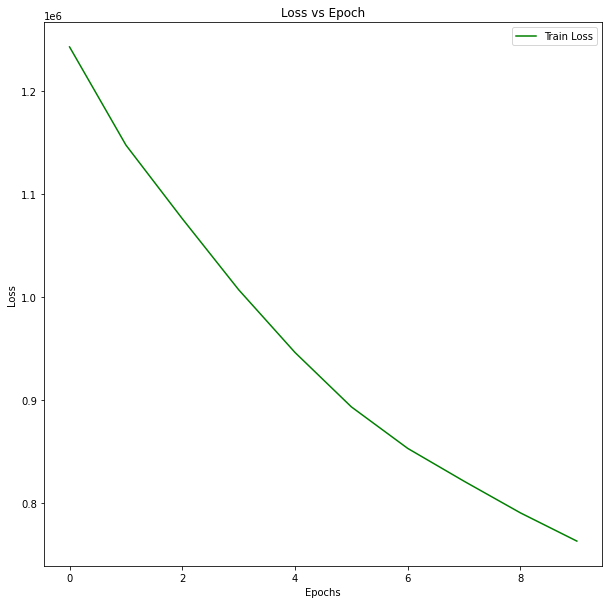

In [13]:
pg = Sequential(name="Sequential")

pg.add_layer(LinearLayer(input_nodes=784, output_nodes=10))
pg.add_layer(Sigmoid())
pg.add_layer(LinearLayer(input_nodes=10, output_nodes=10))
pg.add_layer(Sigmoid())

pg.build_model(loss=CrossentropyLoss, lr=0.01)
n = -1
pg.fit_model(xtrain[:], ytrain[:], batch_size=32, epochs=10, val_split=None, stop_loss=0.001)
pg.display()

In [14]:
pg.loss.forward(ytest,np.array(pg.predict(xtest)))

<ipython-input-6-60b7572ef512>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=target.astype(np.float)
<ipython-input-6-60b7572ef512>:16: RuntimeWarning: invalid value encountered in log
  + (1 - y) * np.nan_to_num(np.log(1 - out), posinf=1, neginf=-1e-10))


141860.9053921613

## Model Second: Softmax with 1 Hidden Layer

<ipython-input-6-60b7572ef512>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=target.astype(np.float)
<ipython-input-6-60b7572ef512>:16: RuntimeWarning: invalid value encountered in log
  + (1 - y) * np.nan_to_num(np.log(1 - out), posinf=1, neginf=-1e-10))


Epoch 0 Train Loss: 18.566841439348828
Epoch 1 Train Loss: 18.488564415500168
Epoch 2 Train Loss: 18.416575521503113
Epoch 3 Train Loss: 18.349937731190476
Epoch 4 Train Loss: 18.287897438302497
Epoch 5 Train Loss: 18.229863737532817
Epoch 6 Train Loss: 18.17535231711599
Epoch 7 Train Loss: 18.123960619609452
Epoch 8 Train Loss: 18.07535117001924
Epoch 9 Train Loss: 18.02923841859338


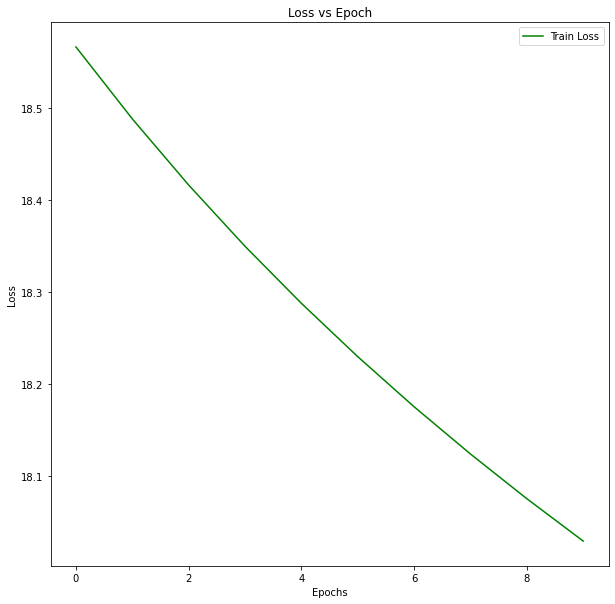

In [15]:
pg = Sequential(name="Sequential")

pg.add_layer(LinearLayer(input_nodes=784, output_nodes=10))
pg.add_layer(Softmax())
pg.add_layer(LinearLayer(input_nodes=10, output_nodes=10))
pg.add_layer(Softmax())

pg.build_model(loss=CrossentropyLoss, lr=0.01)
n = 1000
pg.fit_model(xtrain[:], ytrain[:], batch_size=32, epochs=10, val_split=None, stop_loss=0.001)
pg.display()


In [16]:
pg.loss.forward(ytest,np.array(pg.predict(xtest)))

<ipython-input-6-60b7572ef512>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=target.astype(np.float)
<ipython-input-6-60b7572ef512>:16: RuntimeWarning: invalid value encountered in log
  + (1 - y) * np.nan_to_num(np.log(1 - out), posinf=1, neginf=-1e-10))


200948.96720438986

## Model Third: Softmax with 2 Hidden Layer

<ipython-input-6-60b7572ef512>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=target.astype(np.float)
<ipython-input-6-60b7572ef512>:16: RuntimeWarning: invalid value encountered in log
  + (1 - y) * np.nan_to_num(np.log(1 - out), posinf=1, neginf=-1e-10))


Epoch 0 Train Loss: 18.5574690450283
Epoch 1 Train Loss: 19.318488395980904
Epoch 2 Train Loss: 19.363393281542983
Epoch 3 Train Loss: 19.516746148069814
Epoch 4 Train Loss: 19.501600860970196
Epoch 5 Train Loss: 19.40676008810925
Epoch 6 Train Loss: 19.071567653562685
Epoch 7 Train Loss: 18.859908007123035
Epoch 8 Train Loss: 18.847080467349986
Epoch 9 Train Loss: 18.888478448721486


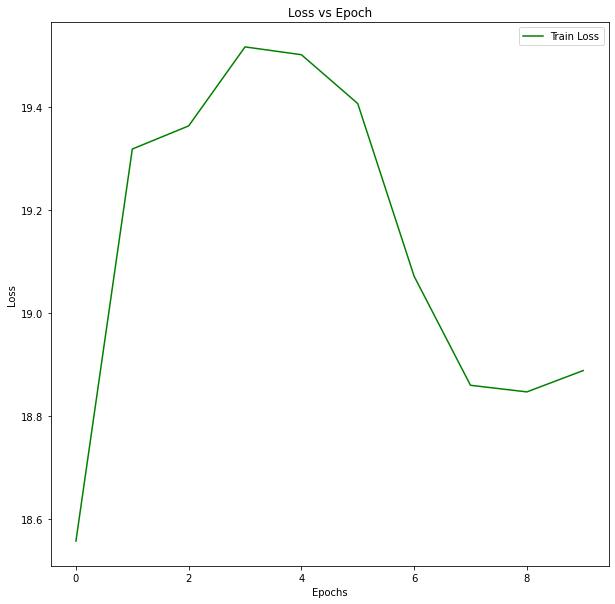

In [17]:
pg = Sequential(name="Sequential")

pg.add_layer(LinearLayer(input_nodes=784, output_nodes=10))
pg.add_layer(LinearLayer(input_nodes=10, output_nodes=10))
pg.add_layer(Sigmoid())
pg.add_layer(LinearLayer(input_nodes=10, output_nodes=10))
pg.add_layer(Softmax())

pg.build_model(loss=CrossentropyLoss, lr=0.01)
n = 1000
pg.fit_model(xtrain[:], ytrain[:], batch_size=32, epochs=10, val_split=None, stop_loss=0.001)
pg.display()


In [18]:
pg.loss.forward(ytest,np.array(pg.predict(xtest)))

<ipython-input-6-60b7572ef512>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=target.astype(np.float)
<ipython-input-6-60b7572ef512>:16: RuntimeWarning: invalid value encountered in log
  + (1 - y) * np.nan_to_num(np.log(1 - out), posinf=1, neginf=-1e-10))


197347.2036497921

# Playing With Hyper Parameters

## Model With All 0s

<ipython-input-6-60b7572ef512>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=target.astype(np.float)
<ipython-input-6-60b7572ef512>:16: RuntimeWarning: invalid value encountered in log
  + (1 - y) * np.nan_to_num(np.log(1 - out), posinf=1, neginf=-1e-10))


Epoch 0 Train Loss: 17.635409310471967
Epoch 1 Train Loss: 17.606887767463764
Epoch 2 Train Loss: 17.57924561289876
Epoch 3 Train Loss: 17.552430333848726
Epoch 4 Train Loss: 17.526393985240446
Epoch 5 Train Loss: 17.501092674647722
Epoch 6 Train Loss: 17.476486118238466
Epoch 7 Train Loss: 17.452537255683865
Epoch 8 Train Loss: 17.429211915149313
Epoch 9 Train Loss: 17.406478520706493


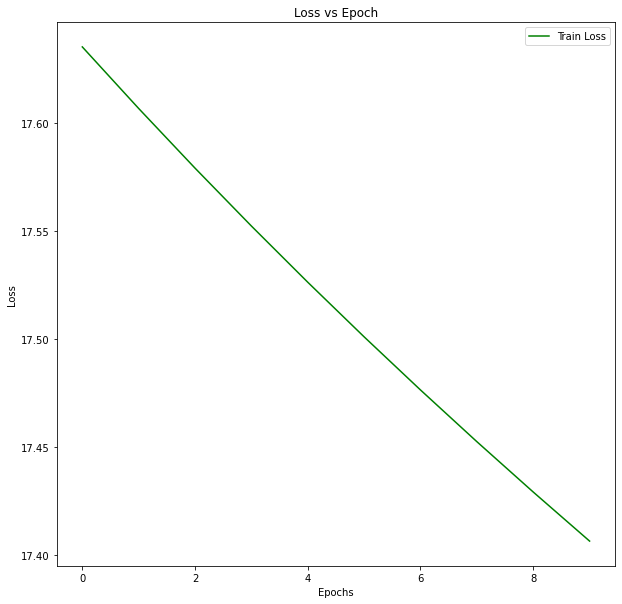

In [19]:
pg = Sequential(name="Sequential")

pg.add_layer(LinearLayer(input_nodes=784, output_nodes=10, weights=np.zeros((784, 10)), bias=np.zeros((10))))
pg.add_layer(Sigmoid())
pg.add_layer(LinearLayer(input_nodes=10, output_nodes=10, weights=np.zeros((10, 10)), bias=np.zeros((10))))
pg.add_layer(Softmax())

pg.build_model(loss=CrossentropyLoss, lr=0.01)
# n = 1000
pg.fit_model(xtrain[:], ytrain[:], batch_size=32, epochs=10, val_split=None, stop_loss=0.001)
pg.display()


## Model With random values between -10 to 10

<ipython-input-20-fccadc3167f8>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  weights=np.random.randint(-10,10,(784, 10)).astype(np.float),
<ipython-input-20-fccadc3167f8>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bias=np.random.randint(-10, 10, (10)).astype(np.float)))
<ipython-input-20-fccadc3167f8>:8: DeprecationWarning: `np.

Epoch 0 Train Loss: 19.281241130560065
Epoch 1 Train Loss: 19.239573881797288
Epoch 2 Train Loss: 19.19702515619551
Epoch 3 Train Loss: 19.153966379547104
Epoch 4 Train Loss: 19.110205459042813
Epoch 5 Train Loss: 19.065180212409317
Epoch 6 Train Loss: 19.01836585772206
Epoch 7 Train Loss: 18.969232284923756
Epoch 8 Train Loss: 18.917336042418864
Epoch 9 Train Loss: 18.862051313270847


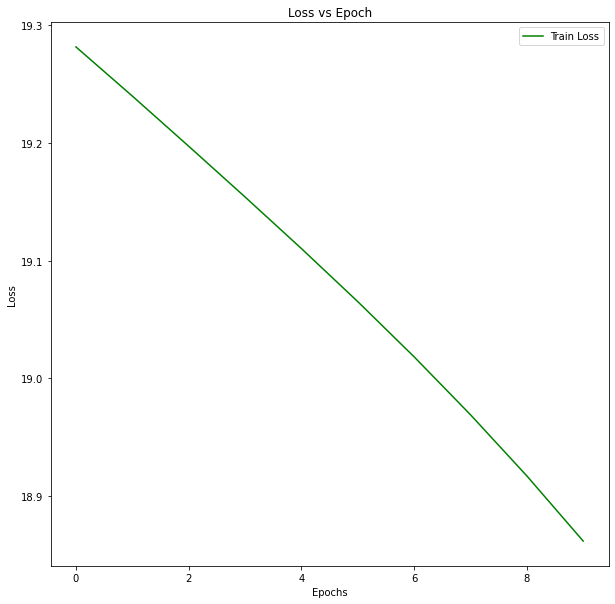

In [20]:
pg = Sequential(name="Sequential")

pg.add_layer(LinearLayer(input_nodes=784, output_nodes=10, 
                    weights=np.random.randint(-10,10,(784, 10)).astype(np.float), 
                    bias=np.random.randint(-10, 10, (10)).astype(np.float)))
pg.add_layer(Sigmoid())
pg.add_layer(LinearLayer(input_nodes=10, output_nodes=10, 
                    weights=np.random.randint(-10, 10, (10, 10)).astype(np.float), 
                    bias=np.random.randint(-10, 10, (10)).astype(np.float)))
pg.add_layer(Softmax())

pg.build_model(loss=CrossentropyLoss, lr=0.01)
n = 1000
pg.fit_model(xtrain[:], ytrain[:], batch_size=32, epochs=10, val_split=None, stop_loss=0.001)
pg.display()


## Model With Learning Rate 1

<ipython-input-6-60b7572ef512>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=target.astype(np.float)
<ipython-input-6-60b7572ef512>:16: RuntimeWarning: invalid value encountered in log
  + (1 - y) * np.nan_to_num(np.log(1 - out), posinf=1, neginf=-1e-10))


Epoch 0 Train Loss: 19.09775292166315
Epoch 1 Train Loss: 19.07844523494795
Epoch 2 Train Loss: 19.059450011279488
Epoch 3 Train Loss: 19.040810868796875
Epoch 4 Train Loss: 19.022514739179993
Epoch 5 Train Loss: 19.004549260582746
Epoch 6 Train Loss: 18.986902727610993
Epoch 7 Train Loss: 18.96956404564978
Epoch 8 Train Loss: 18.952522689095826
Epoch 9 Train Loss: 18.935768663099815


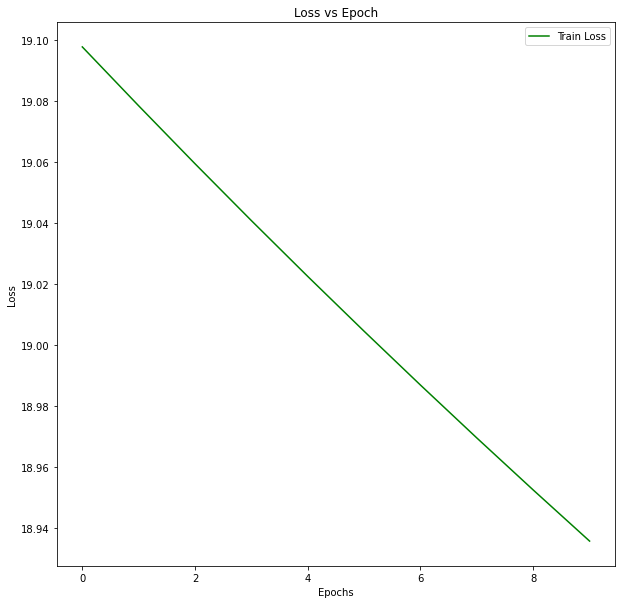

In [21]:
pg = Sequential(name="Sequential")

pg.add_layer(LinearLayer(input_nodes=784, output_nodes=10))
pg.add_layer(Sigmoid())
pg.add_layer(LinearLayer(input_nodes=10, output_nodes=10))
pg.add_layer(Softmax())

pg.build_model(loss=CrossentropyLoss, lr=1)
n = 1000
pg.fit_model(xtrain[:], ytrain[:], batch_size=32, epochs=10, val_split=None, stop_loss=0.001)
pg.display()


## Model With Learning Rate 0.001


<ipython-input-6-60b7572ef512>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=target.astype(np.float)
<ipython-input-6-60b7572ef512>:16: RuntimeWarning: invalid value encountered in log
  + (1 - y) * np.nan_to_num(np.log(1 - out), posinf=1, neginf=-1e-10))


Epoch 0 Train Loss: 17.553786934024274
Epoch 1 Train Loss: 17.368925926132608
Epoch 2 Train Loss: 17.253696463629183
Epoch 3 Train Loss: 17.187223428532004
Epoch 4 Train Loss: 17.141485790702124
Epoch 5 Train Loss: 17.104056129027487
Epoch 6 Train Loss: 17.069937143419704
Epoch 7 Train Loss: 17.039586852680294
Epoch 8 Train Loss: 17.019982706255366
Epoch 9 Train Loss: 17.009305062816505


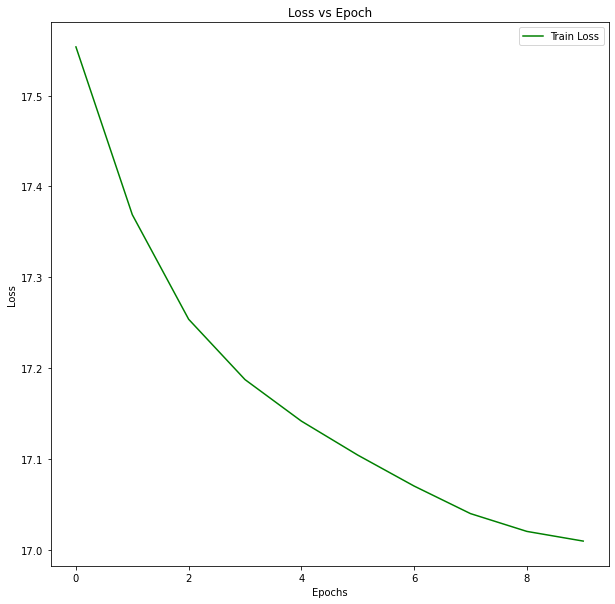

In [24]:
pg = Sequential(name="Sequential")

pg.add_layer(LinearLayer(input_nodes=784, output_nodes=10))
pg.add_layer(Sigmoid())
pg.add_layer(LinearLayer(input_nodes=10, output_nodes=10))
pg.add_layer(Softmax())

pg.build_model(loss=CrossentropyLoss, lr=0.001)
n = 1000
pg.fit_model(xtrain[:], ytrain[:], batch_size=32, epochs=10, val_split=None, stop_loss=0.001)
pg.display()
